In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from game_environments.breakthrough.breakthrough import BTBoard, config as BTconfig
import random
from tqdm import tqdm
from PIL import Image
import ast
from itertools import permutations
from monte_carlo.mcts import MCTS
from monte_carlo.mctsnode import Node

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

GAME = {
    "breakthrough": BTBoard(np.zeros([6,6]), 1),
}
selected_game = GAME["breakthrough"]
initial_state = selected_game.initial_state()
seen_states = {}

frontier = [initial_state]

generate_new_data = False

if generate_new_data:
    df = pd.DataFrame(columns=["id",
                               "player",
                               "state",
                               "terminal", 
                               "player_piece_amount", 
                               "piece_difference", 
                               "furthest_piece", 
                               "furthest_piece_difference"], 
                      dtype=np.int64
                      )
    state_id = 0

    while frontier and state_id < 10000:
        working_state = frontier.pop()
        if working_state.__hash__() in seen_states:
            continue


        heuristics = working_state.get_heuristics()
        df = df.append({
            'id':state_id,
            'state':working_state.encode_state(),
            'player':min(working_state.player+1,1),
            'terminal':working_state.is_terminal(),
            'player_piece_amount':heuristics[0][1],
            'piece_difference':heuristics[1][1],
            'furthest_piece':heuristics[2][1],
            'furthest_piece_difference':heuristics[3][1]
        },ignore_index=True)
        
        state_id += 1
        seen_states[working_state.__hash__()] = True
        np.random.shuffle(working_state.legal_moves)
        for lm in working_state.legal_moves:
            frontier.append(working_state.execute_move(lm))
    df.set_index('id') 

    df.to_csv('./dfs_moves_heuristic_10000.csv')
else:
    df = pd.read_csv('./dfs_moves_heuristic_10000.csv', converters={'state': from_np_array}).set_index('id')


plt.imshow(df.iloc[0,2]*np.array([1,1,0]))
plt.show()
tdf = df[df['terminal'] == True]
for i,row in tdf.iterrows():
    plt.imshow(row['state'] * np.array([1,1,0]))
    plt.show()


In [2]:
import torch
import torch.optim as optim
import numpy as np
from game_environments.breakthrough.breakthrough import BTBoard,config
from neural_networks.breakthrough.breakthrough_nn import BreakthroughNN


GAME = {
    "breakthrough": BTBoard(np.zeros([6,6]), 1),
}
selected_game = GAME["breakthrough"]
initial_state = selected_game.initial_state()

net = BreakthroughNN(initial_state.rows, initial_state.cols, initial_state.get_move_amount())
net.loadmodel('./trained_models', 'gen_61.tar')


In [3]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


class StateDataset(Dataset):
    def __init__(self, _x, _y):
        self.X = _x.copy()
        self.y = _y.copy()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X.iloc[idx], self.y.iloc[idx]



# X = df['state']
# y = df['piece_difference']


# stateDS = StateDataset(X,y)

# stateDL = DataLoader(stateDS, batch_size=1)

positive = df[df['piece_difference'] > 1].sample(50)
random = df[df['piece_difference'] <= 1].sample(50)

piece_difference_tcav_df = pd.concat([positive, random])

piece_diff_X = piece_difference_tcav_df['state']
piece_diff_y = piece_difference_tcav_df['piece_difference']

piece_diff_DS = StateDataset(piece_diff_X,piece_diff_y)
piece_diff_DL = DataLoader(piece_diff_DS, shuffle=True, batch_size=1)

all_X = df['state']
all_y = df['piece_difference']
all_DS = StateDataset(all_X,all_y)
all_DL = DataLoader(all_DS, shuffle=True, batch_size=1)




In [4]:
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.metrics import roc_auc_score
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

concept_list = []
activations_list = []
target_list = []

outputs = []

for batch_idx, (data, target) in enumerate(piece_diff_DL):
    data.to(device), target.to(device)
    
    activations = net.forward_0(data.float())
    activations_list.append(activations.clone().detach().cpu())
    concept_list.append(target.item() > 1)
    outputs.append(net.forward_1(activations))

In [5]:
lm = LogisticRegression(max_iter=1000)
lm = LinearRegression()
lm = SGDClassifier(max_iter=1000)



tcav_x = [act.flatten().numpy() for act in activations_list]
tcav_y = concept_list

tcav_x_train, tcav_x_test, tcav_y_train, tcav_y_test = train_test_split(tcav_x, tcav_y, test_size=0.33)

lm.fit(tcav_x_train, tcav_y_train)
y_pred = lm.predict(tcav_x_test)

roc_auc = roc_auc_score(tcav_y_test, y_pred)

CAV = lm.coef_

print("ROC AUC score:", roc_auc)
print("CAV:",CAV)

ROC AUC score: 1.0
CAV: [[ 0.16384322  0.90473039  0.3270915  ... -3.51481566 -2.01833183
  -1.93851642]]


In [8]:
scores = []
flat_cav = CAV.flatten()
counter = 0

corrolated_white = 0
corrolated_black = 0
no_corrolation = 0
corrolated_no_piece_difference = 0
amount = 0
highest_tcav_score = -1000000000
highest_data = None
action_taken = -1

white_count = 0
black_count = 0

player_white = True

for batch_idx, (data, target) in enumerate(all_DL):
    data.to(device), target.to(device)
    activations = net.forward_0(data.float())
    
    acts_var = torch.autograd.Variable(activations.clone().detach().to(device), requires_grad=True)
    outputs = net.forward_1(acts_var)
    
    # get the action we would take doing mcts
    #curr_node = Node(data)
    
    # get output we want the gradient wrt (move it picked or the score it gave)
    midx = torch.argmax(outputs[0]).item()
#     print(outputs[0])
#     print(outputs[0][0][midx])
#     for idx,k in enumerate(outputs[0]):
#         print(idx,k)
#     print(midx)
#     break

    # grad wrt value
#     grad = -torch.autograd.grad(outputs[1], acts_var)[0]
    
    # grad wrt highest action in policy vector
    grad = torch.autograd.grad(outputs[0][0][midx], acts_var)[0]
    
    tcav_score = np.dot(grad.detach().cpu().numpy().flatten(), flat_cav)
    white_count = data[0,0].sum().item()
    black_count = data[0,1].sum().item()
    player_white = data[0,2,0,0].item() == 1
    
    if player_white and white_count > black_count and tcav_score > 0:
        corrolated_white += 1
    elif not player_white and white_count < black_count and tcav_score > 0:
        corrolated_black += 1
    elif white_count == black_count and abs(tcav_score) < 0.1:
        corrolated_no_piece_difference += 1
    elif abs(tcav_score) > 0.1:
        no_corrolation += 1
        
    if tcav_score > highest_tcav_score:
        highest_tcav_score = tcav_score
        highest_data = data
        action_taken = midx
    amount += 1
    
print("corrolated white {} \ncorrolated_black {}\nno_corrolation {}\namount {}".format(corrolated_white, corrolated_black, no_corrolation, amount))
print("corrolated_no_piece_difference: ",corrolated_no_piece_difference)
highest_data = highest_data.detach().numpy()[0]
print(highest_data)
print("action taken: ", action_taken)
# plt.imshow(highest_data)
# plt.show()
    

corrolated white 1645 
corrolated_black 0
no_corrolation 4534
amount 10000
corrolated_no_piece_difference:  1
[[[0. 0. 0. 0. 0. 0.]
  [1. 0. 1. 1. 1. 1.]
  [1. 1. 0. 1. 0. 1.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0.]
  [0. 1. 0. 1. 0. 0.]
  [0. 0. 1. 1. 0. 0.]
  [0. 1. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]]]
action taken:  19


BOARD STATE
Turn:  Black
Terminal: True | Winner: white
---------------
0 · · · w · ·
1 w · w w · w
2 w w b w w ·
3 · · · b · ·
4 · b b b b ·
5 · · · · · ·
  0 1 2 3 4 5
---------------
legal moves: []


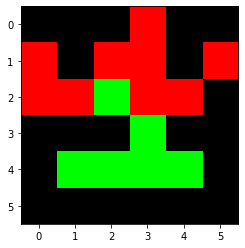

In [7]:
player = 1 if highest_data[2,0,0] == 0 else -1
to_bt_board = highest_data[0] * -1
to_bt_board += highest_data[1]
test = Node(BTBoard(to_bt_board,player),"START")
test.gamestate.print_board()
masked_highest_data = highest_data
masked_highest_data[2,:,:] = 0
# print(highest_data)
# print(masked_highest_data)

plt.imshow(masked_highest_data.transpose(1,2,0))